In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import datetime as dt
import matplotlib.pyplot as plt


In [ ]:
Importation de données 

In [ ]:
DATA_PATH = 'La myriade de Totems de Montpellier - SaisiesFormulaire (3).csv'

In [3]:
def load_data(path = DATA_PATH):
    df = pd.read_csv(path, header = 0)
    df.columns = ['date', 'time', 'total', 'value', 'unnamed', 'observation']
    df.drop(['unnamed', 'observation', 'total'], axis = 1, inplace = True)
    # remove records (rows) having nan values
    df.dropna(inplace = True)
    # datetime index
    df.index = df['date'].str.cat(' ' + df['time']) 
    df.index = pd.to_datetime(df.index, format = '%d/%m/%Y %H:%M:%S')
    df.index.name = 'datetime'
    # remove columns date and time because we have them as index now, as well as total because we don't need it
    df.drop(['date', 'time'], axis = 1, inplace = True) 
    return df

In [4]:
df = load_data()
# df[df['date'] == dt.datetime(2020, 3, 12)]
df.head()

,value
datetime,
2020-03-12 11:05:00,109.0
2020-03-12 14:30:00,441.0
2020-03-13 10:02:00,385.0
2020-03-13 14:15:00,769.0
2020-03-13 18:21:00,1286.0


In [5]:
def estimate_value_at_9am(A, B, m_A, m_B):
    return np.ceil(((B - A) / (m_B - m_A)) * 540 + ((A * m_B - B * m_A) / (m_B - m_A)))

df['date'] = df.index.floor('D')

d = dict()
for k, v in df.groupby('date').groups.items():
    v = list(v)
    if len(v) == 1:
        m_A = dt.datetime.combine(v[0].date(), dt.datetime.min.time())
        m_B = v[0]
        A = 0
        B = df.loc[m_B, 'value']
    else:
        m_A = dt.datetime.combine(v[0].date(), dt.datetime.min.time())
        m_9am = dt.datetime.combine(v[0].date(), dt.time(9))
        i = 0
        while i < len(v) and v[i] < m_9am:
            m_A = v[i]
            i = i + 1
        if i == len(v):
            m_A = v[i - 2]
            m_B = v[i -1]
            A = df.loc[m_A, 'value']
            B = df.loc[m_B, 'value']
        else:
            m_B = v[i]
        if m_A.time() == dt.datetime.min.time():
            A = 0
        else:
            A = df.loc[m_A, 'value']
        B = df.loc[m_B, 'value']
    m_A = m_A.hour * 60 + m_A.minute
    m_B = m_B.hour * 60 + m_B.minute
    V = estimate_value_at_9am(A, B, m_A, m_B)
    d[m_9am] = V

ts = pd.Series(index = list(d.keys()), data = list(d.values()))

In [6]:
# computing the moving average

ts_ma = ts.rolling(window = 14).mean()
ts_ma[ts_ma.isna()] = 0

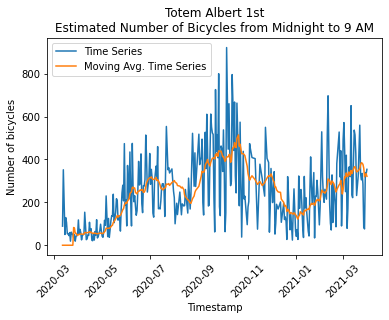

In [7]:
x = ts.index.tolist()
y = ts.values
x_ma = ts_ma.index.tolist()
y_ma = ts_ma.values

plt.figure()
plt.plot(x, y)
plt.plot(x_ma, y_ma)
plt.title('Totem Albert 1st\nEstimated Number of Bicycles from Midnight to 9 AM')
plt.xlabel('Timestamp')
plt.xticks(rotation = 45)
plt.ylabel('Number of bicycles')
plt.legend(['Time Series', 'Moving Avg. Time Series'])
plt.show()

In [8]:
# first, we need to turn our problem to a supervised learning problem

p = 14
ts_use = ts_ma

df_sl = pd.DataFrame(columns = [f'x_{i}' for i in range(p)] + ['y'])
for i in range(ts_use.shape[0] - p):
    df_sl.loc[i] = [ts_use[i + j] for j in range(p + 1)]

X = df_sl.iloc[:, :-1].values
y = df_sl.iloc[:, -1].values

In [9]:
# second, we splot our data set into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, shuffle = False)

In [10]:
# feature scaling

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [11]:
# feature scaling

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [12]:
# AR(p) - linear regression

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred

array([129.84474847, 122.79136989, 134.69500858, 141.81625313,
       158.94027233, 150.45634904, 150.52640211, 151.8768048 ,
       144.01372336, 168.10269477, 161.58867214, 160.99864223,
       165.29222324, 169.11085387, 172.51564028, 184.51645383,
       188.92367341, 197.90019391, 194.47238981, 197.16481427,
       186.17057036, 201.34857315, 211.45705635, 207.24539796,
       216.66280071, 207.93454988, 208.27541887, 218.57706488,
       240.1086417 , 259.90734038, 252.23090379, 247.92852488,
       247.06036091, 249.52255156, 261.87755393, 272.58957329,
       310.75517767, 304.81205591, 291.90167004, 280.5315691 ,
       306.47581082, 304.21979707, 284.68821226, 251.28947711,
       240.39141557, 262.65589032, 282.74447412, 284.69035083,
       299.27374719, 268.0630015 , 240.4887171 , 266.4961343 ,
       299.19793971, 328.22653769, 310.21092398, 330.15659231,
       326.40132971, 340.90978935, 346.43826045, 332.04383691,
       328.25794939, 345.99996856, 328.08488525, 347.17

In [13]:
# quality of predictions

r2_score(y_test, y_pred)

0.9642657775420271

In [16]:
pd.DataFrame({
    'y_test_ma': list(y_test),
    'y_pred_ma': list(y_pred),
    'y_orig': ts[ts.shape[0] - y_pred.shape[0]:]
}).tail(30)

,y_test_ma,y_pred_ma,y_orig
2021-02-27 09:00:00,272.142857,299.273747,90.0
2021-02-28 09:00:00,239.142857,268.063001,235.0
2021-03-01 09:00:00,260.928571,240.488717,494.0
2021-03-02 09:00:00,294.500000,266.496134,572.0
2021-03-03 09:00:00,320.214286,299.197940,431.0
2021-03-04 09:00:00,314.642857,328.226538,250.0
2021-03-05 09:00:00,337.071429,310.210924,420.0
2021-03-06 09:00:00,322.285714,330.156592,79.0
2021-03-07 09:00:00,321.214286,326.401330,171.0
2021-03-08 09:00:00,340.928571,340.909789,362.0
